In [83]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm
from datetime import datetime
import math
import cv2

In [2]:
T = 1000
max_noise = 0.02

betas = torch.linspace(0.001, max_noise, T)
alphas = 1-betas
alphas_cp = torch.cumprod(alphas, dim=0)

In [3]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
val_ds = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=True)

tensor(480)


Text(0.5, 1.0, '$hat_{X_o}$')

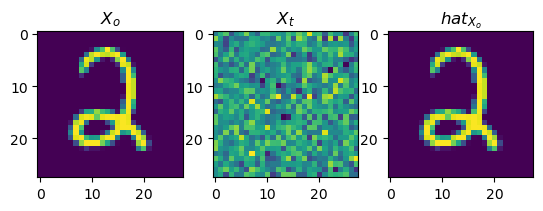

In [4]:
def generate_noised_img(x0: torch.Tensor, t: torch.Tensor):
    eps = torch.randn_like(x0)
    alpha_cp = alphas_cp[t.int().flatten()]
    xt = torch.sqrt(alpha_cp)[:, None, None, None] * x0 + torch.sqrt(1 - alpha_cp)[:, None, None, None] * eps

    return xt, eps


def denoise_img(xt: torch.Tensor, t: torch.Tensor, eps: torch.Tensor) -> torch.Tensor:
    if len(xt.shape) != 4:
        raise Exception(f"Expected Xt of shape B x C x H x W, got {xt.shape}")
    alpha_cp = alphas_cp[t.int().flatten()]
    return 1 / torch.sqrt(alpha_cp)[:, None, None, None] * (xt - torch.sqrt(1 - alpha_cp)[:, None, None, None] * eps)
    
def step_back(xt: torch.Tensor, t: torch.Tensor, eps_pred: torch.Tensor) -> torch.Tensor:
    if len(xt.shape) != 4:
        raise Exception(f"Expected Xt of shape B x C x H x W, got {xt.shape}")
        
    t = t.int().flatten()
    alpha = alphas[t][:, None, None, None]
    alpha_cp = alphas_cp[t][:, None, None, None]
    res = (1/torch.sqrt(alpha)) * (xt - (1-alpha) / torch.sqrt(1-alpha_cp) * eps_pred)
    
    if t <= 0:
        return res
    
    z = torch.randn_like(xt)
    std = torch.sqrt(betas[t])[:, None, None, None]
    return res + z * std


dummy_batch_x0, dummy_batch_labels = next(iter(train_loader))  # (B x 1 x 28 x 28), (B,)

t = torch.randint(0, T, size=(dummy_batch_x0.shape[0],))
dummy_batch_xt, dummy_batch_eps = generate_noised_img(dummy_batch_x0, t)
print(t[0])

denoised_img = denoise_img(dummy_batch_xt, t, dummy_batch_eps)

plt.subplot(131)
plt.imshow(dummy_batch_x0[0][0])
plt.title("$X_o$")

plt.subplot(132)
plt.imshow(dummy_batch_xt[0][0])
plt.title("$X_t$")

plt.subplot(133)
plt.imshow(denoised_img[0][0])
plt.title("$hat_{X_o}$")

In [115]:
class TimeEmbedding(nn.Module):
    def __init__(self, d):
        super().__init__()
        if d % 2 != 0:
            raise Exception("Dimension must be even")
        self.d = d
        
    def forward(self, t: torch.Tensor):
        # t (B x 1)
        t = t.view(-1, 1)
        
        exponent = torch.arange(0, self.d//2) / self.d
        den = torch.exp(-math.log(10e3) * exponent)
        
        args = torch.cat([torch.sin(t * den), torch.cos(t*den)], dim=1)
        return args

time_model = TimeEmbedding(d=8)
time_model(torch.tensor([1, 2, 3]))


tensor([[ 0.8415,  0.3110,  0.0998,  0.0316,  0.5403,  0.9504,  0.9950,  0.9995],
        [ 0.9093,  0.5911,  0.1987,  0.0632, -0.4161,  0.8066,  0.9801,  0.9980],
        [ 0.1411,  0.8126,  0.2955,  0.0947, -0.9900,  0.5828,  0.9553,  0.9955]])

In [158]:
img_sz = 28
p_dropout = 0.3
time_emb_dim = 64


class DownBlock(nn.Module):
    def __init__(self, c_in, c_out) -> None:
        super().__init__()

        self.time_mlp = nn.Linear(time_emb_dim, c_out)
        self.c_out = c_out

        self.conv1 = nn.Sequential(
            nn.Conv2d(c_in, c_out, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups=1, num_channels=c_out),
            nn.GELU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(c_out, c_out, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups=1, num_channels=c_out),
            nn.GELU(),
        )

        self.pool = nn.MaxPool2d(2)

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        t = self.time_mlp(t).view(-1, self.c_out, 1, 1)
        x = self.conv1(x)
        x = x + t
        skip = self.conv2(x)
        return self.pool(skip), skip


class UpBlock(nn.Module):
    def __init__(self, c_in, c_out):
        super().__init__()
        self.c_out = c_out

        self.time_mlp = nn.Linear(time_emb_dim, c_out)

        self.up = nn.ConvTranspose2d(c_in, c_out, kernel_size=2, stride=2)

        self.conv1 = nn.Sequential(
            nn.Conv2d(c_out * 2, c_out, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups=1, num_channels=c_out),
            nn.GELU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(c_out, c_out, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups=1, num_channels=c_out),
            nn.GELU(),
        )

    def forward(self, x: torch.Tensor, skip: torch.Tensor, t: torch.Tensor):
        t = self.time_mlp(t).view(-1, self.c_out, 1, 1)
        x = self.up(x)
        x = torch.cat((x, skip), dim=1)

        x = self.conv1(x)
        x = x + t

        return self.conv2(x)


class BottleNeck(nn.Module):
    def __init__(self, c_in, c_out):
        super().__init__()
        self.c_out = c_out

        self.time_mlp = nn.Linear(time_emb_dim, c_out)

        self.conv1 = nn.Sequential(
            nn.Conv2d(c_in, c_out, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups=1, num_channels=c_out),
            nn.GELU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(c_out, c_out, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups=1, num_channels=256),
            nn.GELU(),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(c_out, c_out, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups=1, num_channels=256),
            nn.GELU(),
        )

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        t = self.time_mlp(t).view(-1, self.c_out, 1, 1)
        x = self.conv1(x)

        x = self.conv2(x + t)
        return self.conv3(x)


class UNet(nn.Module):
    def __init__(self, c_in):
        super().__init__()

        self.time_mlp = nn.Sequential(
            TimeEmbedding(64),
            nn.Linear(64, 64),
            nn.GELU(),
            nn.Linear(64, 64),
        )

        self.down_blocks = nn.ModuleList(
            (
                DownBlock(c_in, 64),  # 28 -> 14
                DownBlock(64, 128),  # 14 -> 7
            )
        )

        self.bottleneck = BottleNeck(128, 256)

        self.up_blocks = nn.ModuleList(
            (
                UpBlock(256, 128),  # 7 -> 14
                UpBlock(128, 64),  # 14 -> 28
            )
        )

        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x: torch.Tensor, t):
        t_embedded = self.time_mlp(t)

        skips = []
        for block in self.down_blocks:
            x, skip = block(x, t_embedded)
            skips.append(skip)

        x = self.bottleneck(x, t_embedded)

        for block in self.up_blocks:
            skip = skips.pop()
            x = block(x, skip, t_embedded)

        return self.final_conv(x)


model = UNet(1)
dummy_x = torch.rand(2, 1, 28, 28)
dummy_t = torch.randint(0, T, size=(2,))
model(dummy_x, dummy_t).shape

torch.Size([2, 1, 28, 28])

In [159]:
run_name = datetime.now().strftime("%Y%m%d-%H%M%S")
writer = SummaryWriter()
writer.add_graph(model, [dummy_x, dummy_t])
writer.close()

In [160]:
avg_train_losses = []
avg_val_losses = []

In [165]:
opt = torch.optim.AdamW(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

In [166]:
epochs = 5
grad_acumm_steps = 4

try:
    for epoch in range(epochs):
        avg_train_loss = 0

        model.train()
        train_bar = tqdm(train_loader, desc="Training")
        for i, (x0, label) in enumerate(train_bar):
            t = torch.randint(low=0, high=T, size=(x0.shape[0],))
            xt, eps = generate_noised_img(x0, t)

            eps_pred = model(xt, t)

            loss = criterion(eps_pred, eps)
            avg_train_loss += loss.item()
            loss.backward()

            if (i + 1) % grad_acumm_steps == 0:
                opt.step()
                opt.zero_grad()

            train_bar.set_postfix(loss=avg_train_loss / (i + 1))
            
            if i == 200:
                break
            
        avg_train_loss /= 200 # len(train_loader)
        with torch.no_grad():
            avg_val_loss = 0
            model.eval()
            val_bar = tqdm(val_loader, desc="Validation")
            for i, (x0, label) in enumerate(val_bar):
                t = torch.randint(low=0, high=T, size=(x0.shape[0],))
                xt, eps = generate_noised_img(x0, t)

                eps_pred = model(xt, t)

                loss = criterion(eps_pred, eps)
                avg_val_loss += loss.item()

                val_bar.set_postfix(loss=avg_val_loss / (i + 1))
                if i == len(val_loader) // 4:
                    break

            avg_val_loss /= len(val_loader) // 4

        avg_train_losses.append(avg_train_loss)
        avg_val_losses.append(avg_val_loss)

        print(f"EPOCH {epoch} | avg train loss {avg_train_loss:.2f} | avg val loss {avg_val_loss:.2f}")
        
except KeyboardInterrupt:
    print("couldn't wait lool")

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

EPOCH 0 | avg train loss 0.03 | avg val loss 0.03


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

EPOCH 1 | avg train loss 0.03 | avg val loss 0.03


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

EPOCH 2 | avg train loss 0.03 | avg val loss 0.02


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

couldn't wait lool


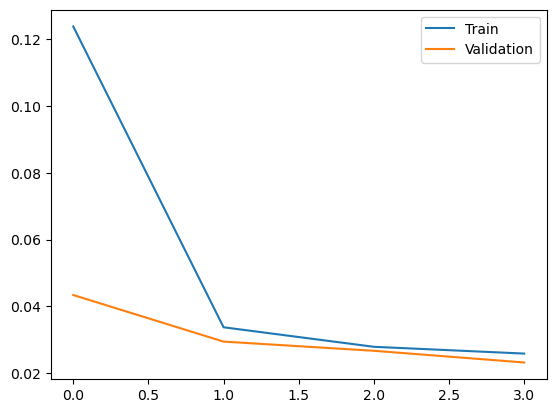

In [167]:
plt.plot(avg_train_losses, label="Train")
plt.plot(avg_val_losses, label="Validation")
plt.legend()

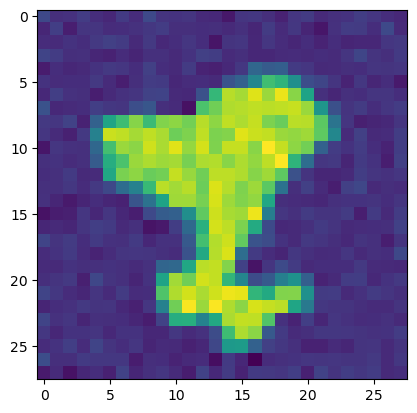

In [172]:
model.eval()
# img = torch.randn((1, 1, 28, 28))

for t in range(T - 1, -1, -1):
    t_tensor = torch.tensor([t])
    pred_noise = model(img, t_tensor)
    pred_noise = pred_noise.view(-1, 1, 28, 28)
    
    img = step_back(img, t_tensor, pred_noise)
    
    if t % 20 == 0:
        img_np = img.flatten(0, 2).detach().numpy()
        img_np = np.clip(img_np, 0, 1)
        img_np = cv2.resize(img_np, (240, 240))
        cv2.imshow("hoho", img_np)
        plt.show()
        if cv2.waitKey(1) == ord('q'):
            cv2.destroyAllWindows()
            break
        
cv2.destroyAllWindows()


plt.imshow(img[0][0].detach().numpy())